# Auswertung der Routen-Eingansdaten

Zur Einordnung der späteren Ergebnisse werden die Eingangsdaten ausgewertet. Dafür wird zuerst die durchschnittsgeschwindigkeit je Verkehrsmittel und Streckentyp berechnet. Aus diesen werden ergeben sich die Fahrtzeiten je Verkehrsmittel. Im zweiten Schritt werden die Streckenlängen und Luftliniengeschwindigkeiten analysiert und grafisch dargestellt. 

In [16]:
import pandas as pd
import configparser
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

In [40]:
path = "../data/data.h5"
oev_list = ["Bus", "Tram", "U-Bahn", "Zug-Nahverkehr", "Zug-Fernverkehr"]

config = configparser.ConfigParser()
config.read("config.ini")

def load_and_format(path):
    """
    Takes the path as arg and reads in the DataFrames from hdf-file.
    """
    output_df = dict()
    for name in config.sections():
        if name in ["rf_pv_Pod", "rf_gv_Pod", "rf_pv_Basis", "rf_gv_Basis"]:
            output_df[name] = (pd.read_hdf(path, key=name)
                                .pipe(extract_col)
                                .rename(columns=str.lower)
                                .drop([f"mode_costs_{i}" for i in range(1,7)], axis=1)
                                .assign(mode_1=lambda x: pd.Categorical(x["mode_1"]),
                                    mode_2=lambda x: pd.Categorical(x["mode_2"]),
                                    mode_3=lambda x: pd.Categorical(x["mode_3"]),
                                    mode_4=lambda x: pd.Categorical(x["mode_4"]),
                                    mode_5=lambda x: pd.Categorical(x["mode_5"]),
                                    mode_6=lambda x: pd.Categorical(x["mode_6"]),
                                    mode_length_1=lambda x: pd.to_numeric(x["mode_length_1"]),
                                    mode_length_2=lambda x: pd.to_numeric(x["mode_length_2"]),
                                    mode_length_3=lambda x: pd.to_numeric(x["mode_length_3"]),
                                    mode_length_4=lambda x: pd.to_numeric(x["mode_length_4"]),
                                    mode_length_5=lambda x: pd.to_numeric(x["mode_length_5"]),
                                    mode_length_6=lambda x: pd.to_numeric(x["mode_length_6"]),
                                    strecken_typ=lambda x: pd.Categorical(x["strecken_typ"])))
        elif name in ["Technologiedaten", "Verbesserungsfaktoren"]:
            output_df[name] = (pd.read_hdf(path, key=name)
                                .rename(columns=str.lower, index=str.lower))
        elif name == "Staedte":
            output_df[name] = (pd.read_hdf(path, key=name)
                                .rename(columns=str.lower)
                                .assign(stadt_typ=lambda x: pd.Categorical(x["stadt_typ"])))
        else:
            output_df[name] = pd.read_hdf(path, key=name)
    return output_df

# Use Funtion to load in DataFrames
#dfs= load_and_format(path)

def extract_col(df):
    """
    drops multiindex
    """
    df = df.copy()
    df.columns = df.columns.droplevel(0)
    return df


def load_dfs(path):
    dfs = dict()
    for name in config.sections():
        dfs[name] = pd.read_hdf(path, key=name)
    return dfs
        
dfs = load_dfs(path)
        
def save_dfs(path, dfs):
    for name in config.sections():
        dfs[name].to_hdf(path, format="table", key=name)
        
        
#save_dfs(path, dfs)

# Extract the DataFrames
cities = dfs["Staedte"]
tech_data = dfs["Technologiedaten"]
improve_data = dfs["Verbesserungsfaktoren"]
rf_pv_basis = dfs["rf_pv_Basis"]
rf_pv_pod = dfs["rf_pv_Pod"]
rf_gv_basis = dfs["rf_gv_Basis"]
rf_gv_pod = dfs["rf_gv_Pod"]
rf_pv_routes = dfs["rf_pv_Strecken"].rename(columns=str.lower).drop('strecken_typ', axis=1)
rf_gv_routes = dfs["rf_gv_Strecken"].rename(columns=str.lower).drop('strecken_typ', axis=1)

In [51]:
# Geschwindigkeiten berechnen
def calc_time_per_vehicle_and_row(row, av_speed, mode, route_typ):
    '''
    Berechnet die 
    '''
    for i in range(1,7):
        if row[f"mode_{i}"] == mode and row['strecken_typ'] == route_typ:
            row[f"mode_time_{i}"] = row[f"mode_length_{i}"]/av_speed[f"{route_typ}-{mode}"]
    return row


def av_calc(df_start, mode):
    '''
    Berechnet die Durchschnittsgeschwindigkeit aus den ermittelten Strecken!
    '''
    df = df_start.copy()
    
    av_speeds = dict()
    
    route_types = ['UK', 'UL', 'I', 'L']
    
    sub_feet_modes = ["MIV", "Taxi"]
    
    for route_typ in route_types:

        if mode in ["zu Fuss",'Fahrrad', 'E-Bike'] and route_typ == "UK":
            av_length = df.loc[
                (df.loc[:,"mode_1"] == mode)
                & (df.loc[:, "strecken_typ"] == route_typ)
                & (df.loc[:, "mode_2"].isnull())
                ]["mode_length_1"].mean()
            av_time = df.loc[
                (df.loc[:,"mode_1"] == mode)
                & (df.loc[:, "strecken_typ"] == route_typ)
                & (df.loc[:, "mode_2"].isnull())
                ]["transferzeit"].mean()
            for i in route_types:
                av_speeds[f'{i}-{mode}'] = av_length/av_time
        elif mode in sub_feet_modes:  # Unterscheidung, da beim Auto die zu Fuss Zeiten subtrahiert werden müssen.
            df_car = df.loc[
                (df.loc[:,'mode_1'].isin(sub_feet_modes)) 
                | (df.loc[:,'mode_2'].isin(sub_feet_modes)) 
                | (df.loc[:,'mode_3'].isin(sub_feet_modes)) 
                | (df.loc[:,'mode_4'].isin(sub_feet_modes))
                | (df.loc[:,'mode_5'].isin(sub_feet_modes))
                | (df.loc[:,'mode_6'].isin(sub_feet_modes))
            ]
            
            
            
            """av_length = df.loc[
                (df.loc[:,"mode_1"] == 'zu Fuss')
                & (df.loc[:, "strecken_typ"] == route_typ)
                & (df.loc[:, "mode_2"].isin(sub_feet_modes))
                & (df.loc[:, 'mode_3'].isnull())
                ]["mode_length_2"].mean()
            av_time = (df.loc[
                            (df.loc[:, "mode_1"] == "zu Fuss")
                            & (df.loc[:,"mode_2"] == mode)
                            & (df.loc[:, "strecken_typ"] == route_typ)
                            & (df.loc[:, "mode_1"] == "zu Fuss")
                            ]["transferzeit"].mean()
                      - df.loc[
                          (df.loc[:, "mode_1"] == "zu Fuss")
                          & (df.loc[:, "strecken_typ"] == route_typ)
                          & (df.loc[:, "mode_2"].isin(sub_feet_modes))
                          & (df.loc[:, 'mode_3'].isnull())
                      ]["mode_time_1"].mean())
            av_speeds[f'{route_typ}-{mode}'] = av_length/av_time"""

        df = (df
            .apply(lambda x: calc_time_per_vehicle_and_row(x, av_speeds, mode, route_typ), axis = 1))
    
    return df, df_speed
        
for mode in ["E-Bike", "zu Fuss", "Fahrrad", "MIV", "Taxi"]:
    rf_pv_basis, df_speed = av_calc(rf_pv_basis, mode)
    
rf_pv_basis.head()

,fahrtzeit,length,mode_1,mode_2,mode_3,mode_4,mode_5,mode_6,mode_length_1,mode_length_2,...,mode_time_1,mode_time_2,mode_time_3,mode_time_4,mode_time_5,mode_time_6,name_verbindung,strecken_typ,transferzeit,wartezeit
index,,,,,,,,,,,,,,,,,,,,,
0.0,30.0000,2500.0,zu Fuss,NaN,NaN,NaN,NaN,NaN,2500.0,NaN,...,31.300813,NaN,NaN,NaN,NaN,NaN,1.0,UK,30.0000,0.0
1.0,8.0000,2600.0,Fahrrad,NaN,NaN,NaN,NaN,NaN,2600.0,NaN,...,9.686275,NaN,NaN,NaN,NaN,NaN,1.0,UK,8.0000,0.0
2.0,16.0000,3600.0,zu Fuss,MIV,NaN,NaN,NaN,NaN,400.0,3200.0,...,5.008130,7.982181,NaN,NaN,NaN,NaN,1.0,UK,16.0000,0.0
3.0,18.0000,3790.0,zu Fuss,U-Bahn,Bus,NaN,NaN,NaN,500.0,1620.0,...,6.260163,NaN,NaN,NaN,NaN,NaN,1.0,UK,19.0000,1.0
4.0,7.0909,2600.0,E-Bike,NaN,NaN,NaN,NaN,NaN,2600.0,NaN,...,7.090904,NaN,NaN,NaN,NaN,NaN,1.0,UK,7.0909,0.0


In [52]:
def find_oev(df_start):
    df = df_start.copy()
    
    df_oev = df.loc[(df.loc[:,'mode_1'].isin(oev_list)) 
                | (df.loc[:,'mode_2'].isin(oev_list)) 
                | (df.loc[:,'mode_3'].isin(oev_list)) 
                | (df.loc[:,'mode_4'].isin(oev_list))
                | (df.loc[:,'mode_5'].isin(oev_list))
                | (df.loc[:,'mode_6'].isin(oev_list))]
    
    return df_oev

df_oev = find_oev(rf_pv_basis)
df_oev

,fahrtzeit,length,mode_1,mode_2,mode_3,mode_4,mode_5,mode_6,mode_length_1,mode_length_2,...,mode_time_1,mode_time_2,mode_time_3,mode_time_4,mode_time_5,mode_time_6,name_verbindung,strecken_typ,transferzeit,wartezeit
index,,,,,,,,,,,,,,,,,,,,,
3.0,18.0,3790.0,zu Fuss,U-Bahn,Bus,NaN,NaN,NaN,500.0,1620.0,...,6.260163,NaN,NaN,NaN,NaN,NaN,1.0,UK,19.0,1.0
8.0,19.0,3340.0,zu Fuss,Zug-Nahverkehr,NaN,NaN,NaN,NaN,1300.0,2040.0,...,16.276423,NaN,NaN,NaN,NaN,NaN,2.0,UK,21.0,2.0
13.0,25.0,3110.0,zu Fuss,Bus,NaN,NaN,NaN,NaN,1850.0,1260.0,...,23.162602,NaN,NaN,NaN,NaN,NaN,3.0,UK,39.0,14.0
17.0,16.0,2740.0,Tram,zu Fuss,NaN,NaN,NaN,NaN,2240.0,500.0,...,NaN,6.260163,NaN,NaN,NaN,NaN,4.0,UK,19.0,3.0
21.0,24.0,2620.0,zu Fuss,Bus,zu Fuss,NaN,NaN,NaN,1200.0,1210.0,...,15.024390,NaN,2.629268,NaN,NaN,NaN,5.0,UK,29.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215.0,443.0,724690.0,zu Fuss,Bus,Zug-Nahverkehr,Zug-Fernverkehr,Taxi,NaN,990.0,17750.0,...,12.395122,NaN,NaN,NaN,NaN,NaN,44.0,L,617.0,174.0
216.0,466.0,721340.0,zu Fuss,Bus,Zug-Nahverkehr,Zug-Fernverkehr,NaN,NaN,2790.0,32750.0,...,34.931707,NaN,NaN,NaN,NaN,NaN,44.0,L,665.0,199.0
218.0,188.0,540100.0,Taxi,zu Fuss,Flugzeug,Bus,Zug-Nahverkehr,NaN,39300.0,1200.0,...,NaN,15.024390,NaN,NaN,NaN,NaN,44.0,L,297.0,109.0


In [19]:
def calc_airspeed(rf_pv_basis, rf_pv_routes):
    df_airspeed_calc = rf_pv_basis.join(rf_pv_routes, on='name_verbindung').drop([
        'stadt_id_start',
        'stadt_start',
        'stadt_ende',
        'stadt_id_ende',
        'startpunkt',
        'endpunkt'
        ], axis = 1)
    df_airspeed_calc = df_airspeed_calc.assign(av_speed=(df_airspeed_calc['luftlinie']/df_airspeed_calc['transferzeit'])*0.06)
    modes_length = [f'mode_length_{i}' for i in range(1,7)]
    modes_time = [f'mode_time_{i}' for i in range(1,7)]
    df_airspeed_calc.drop(modes_length + modes_time, axis = 1)
    return df_airspeed_calc

df = calc_airspeed(rf_pv_basis, rf_pv_routes)

In [20]:
def how_to_add(row, tmp, verkehrsmittel, mode):
    """
    Für die anteilige Berechnung der Verkehrsmittel wird ermittelt, welches
    Verkehrsmittel den größten Anteil an der Gesamtstrecke hat.
    Dafür müssen zunächst die Verkehrsmittel dem dict hinzugefügt werden.

    """
    if verkehrsmittel in tmp.keys():
        tmp[verkehrsmittel] += row[mode[2]]
    else:
        tmp[verkehrsmittel] = row[mode[2]]
    return tmp


def f1(row, modes):
    """f1(row)
    Verkehrsmittel in eine Spalte schreiben und Verkehrsmittel des
    ÖV zusammenfassen.

    """
    tmp = dict()
    for mode in modes:
        if row[mode[0]] in oev_list:
            tmp = how_to_add(row, tmp, "ÖV", mode)

        elif row[mode[0]] == "Pod_Straße_Small":
            tmp = how_to_add(row, tmp, "Pod_Small", mode)
            tmp["Pod_Small"] = 10000000
            break

        elif row[mode[0]] == "Pod_Straße_Big":
            tmp = how_to_add(row, tmp, "Pod_Big", mode)
            tmp["Pod_Big"] = 10000000
            break

        elif row[mode[0]] == "MIV":
            tmp = how_to_add(row, tmp, "MIV", mode)

        elif row[mode[0]] in ["E-Bike", "Fahrrad"]:
            tmp = how_to_add(row, tmp, "Fahrrad", mode)

        elif isinstance(row[mode[0]], str):
            tmp = how_to_add(
                row, tmp, row[mode[0]], mode)

    mode_max = max(tmp, key=tmp.get)
    if mode_max == "zu Fuss" and len(tmp) > 1:
        tmp.pop('zu Fuss', None)
        mode_max = max(tmp, key=tmp.get)
    return mode_max


def sum_modes_oev(df_start):
    '''
    Fügt die Modes zu einer Spalte zusammen und entfernt die restlichen Spalten (mode_1, ... , mode_n)
    '''
    df = df_start.copy()

    modes = [("mode_{0}".format(i), "mode_costs_{0}".format(
            i), "mode_length_{0}".format(i), "mode_time_{0}".format(i)) for i in range(1, 6 + 1)]

    df["modal_choice"] = df.apply(lambda row: f1(row, modes), axis=1)
    
    df = df.drop(
        [f'mode_{i}' for i in range(1,7)] + [f'mode_length_{i}' for i in range(1,7)] + [f'mode_time_{i}' for i in range(1,7)],
        axis=1)
    
    return df

df = sum_modes_oev(df)

# Darstellung der Luftliniengeschwindigkeiten

,fahrtzeit,length,name_verbindung,strecken_typ,transferzeit,wartezeit,luftlinie,av_speed,modal_choice
index,,,,,,,,,
0.0,30.0000,2500.0,1.0,UK,30.0000,0.0,2000.0,4.000000,zu Fuss
1.0,8.0000,2600.0,1.0,UK,8.0000,0.0,2000.0,15.000000,Fahrrad
2.0,16.0000,3600.0,1.0,UK,16.0000,0.0,2000.0,7.500000,MIV
3.0,18.0000,3790.0,1.0,UK,19.0000,1.0,2000.0,6.315789,ÖV
4.0,7.0909,2600.0,1.0,UK,7.0909,0.0,2000.0,16.923099,Fahrrad


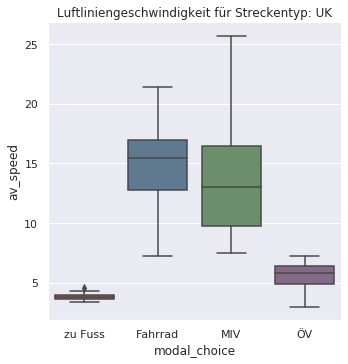

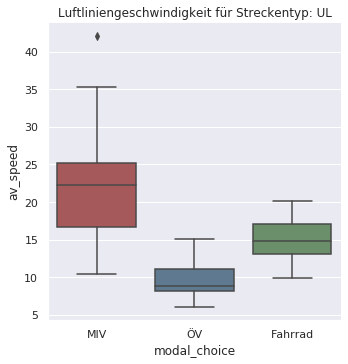

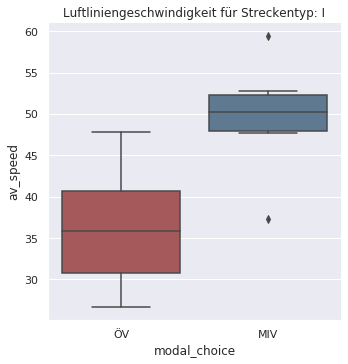

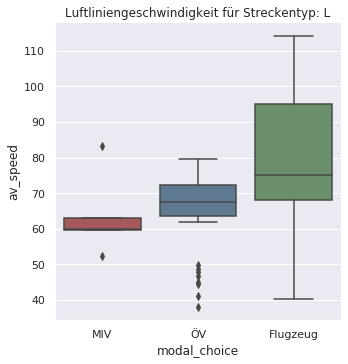

In [21]:
sns.set()
sns.set_palette("Set1", n_colors=8, desat=.5)

display(HTML(df.head().to_html()))

grouped = df.groupby("strecken_typ")

for n in ['UK', 'UL', 'I', 'L']:
    grp = grouped.get_group(n)
    sns.catplot(x="modal_choice",y="av_speed", kind="box", data=grp)
    plt.title(f'Luftliniengeschwindigkeit für Streckentyp: {n}', size=12)
    
plt.show()

# Darstellung der durchschnittlichen Streckenlängen


,Streckenlänge,Einheit
UK,2.72,km
UL,15.63,km
I,183.47,km
L,554.83,km


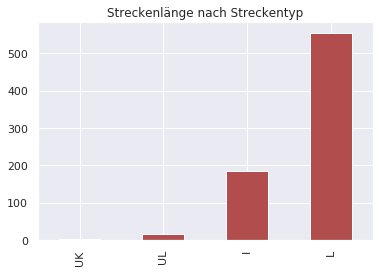

In [31]:
grouped = df.groupby("strecken_typ")

av_route_length = dict()

for n, group in grouped:
    av_route_length[n] = [round(group.loc[:,"length"].mean()/1000, 2) ,'km']
    
df_route_length = pd.DataFrame.from_dict(av_route_length, orient="index" ,columns=["Streckenlänge", 'Einheit']).sort_values(['Streckenlänge'])
df_route_length.plot(kind="bar", title='Streckenlänge nach Streckentyp', legend=False)

display(HTML(df_route_length.to_html()))
plt.show()